# Multiple - Hyperspectral image analysis and classification

In [1]:
%%capture
!python -m pip install abraia
!python -m pip install wget

import os
if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

import numpy as np
import matplotlib.pyplot as plt
from abraia import Multiple, hsi

np.set_printoptions(precision=2)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

multiple = Multiple()

## Download and read the HSI data

As an example, we'll use the Indian Pines (IP) Hyperspectral Image Dataset. It was gathered using the AVIRIS sensor over the Indian Pines test site in North-western Indiana and it consists of images of 145 X 145 pixels and 200 spectral bands, with 16 labels over the image. Here are the Ground Truth details of the IP dataset:

![Indian pines labels](https://miro.medium.com/max/775/1*XFC1rD8kpAxowJGuCch3ow.png)

*Ground Truth Details of Indian Pines (IP) Dataset*

In [2]:
hsiImg, gt, class_names = hsi.load_dataset('IP')

print(f'HSI image size (width, height, #bands): {hsiImg.shape}')
print(f'Ground truth image size (width, height): {gt.shape}')

ValueError: not enough values to unpack (expected 3, got 2)

## Visualize bands and ground truth

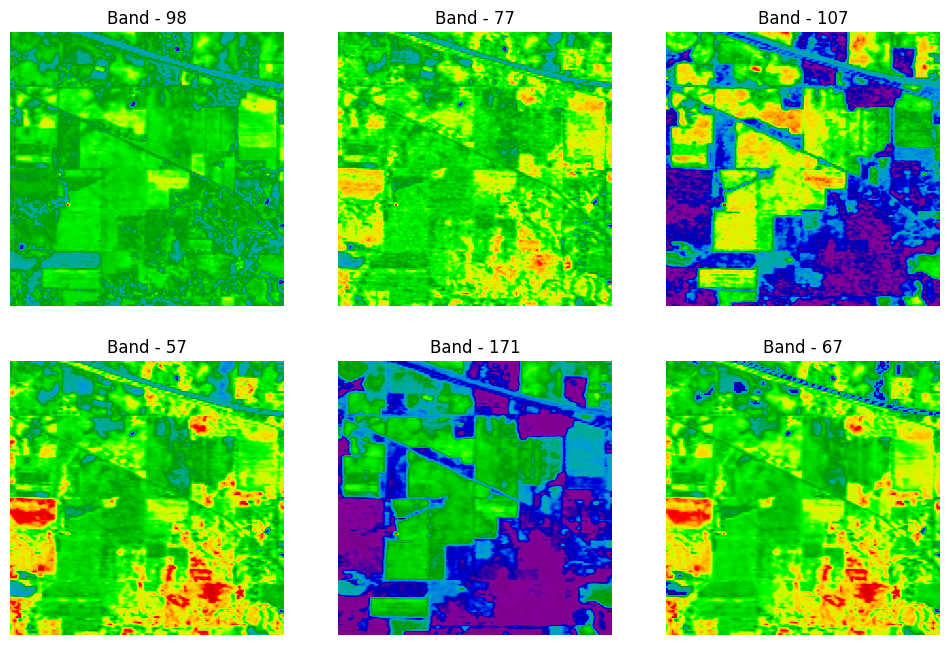

In [ ]:
# Some random bands
imgs, indexes = hsi.random(hsiImg)

ax = plt.subplots(2, 3)[1].reshape(-1)
for i, img in enumerate(imgs):
    ax[i].title.set_text(f'Band - {indexes[i]}')
    ax[i].imshow(img, cmap='nipy_spectral')
    ax[i].axis('off')

(-0.5, 144.5, 144.5, -0.5)

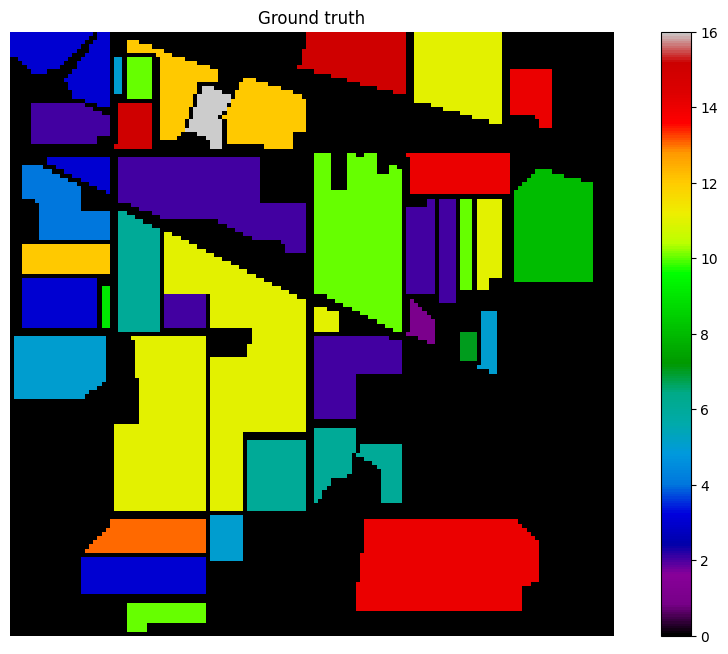

In [ ]:
plt.title('Ground truth')
plt.imshow(gt, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

## Dimensionality reduction (PCA) and visualization

First, we analyze the redundancy in the data available using PCA decomposition.

Text(0, 0.5, 'Cumulative explained variance')

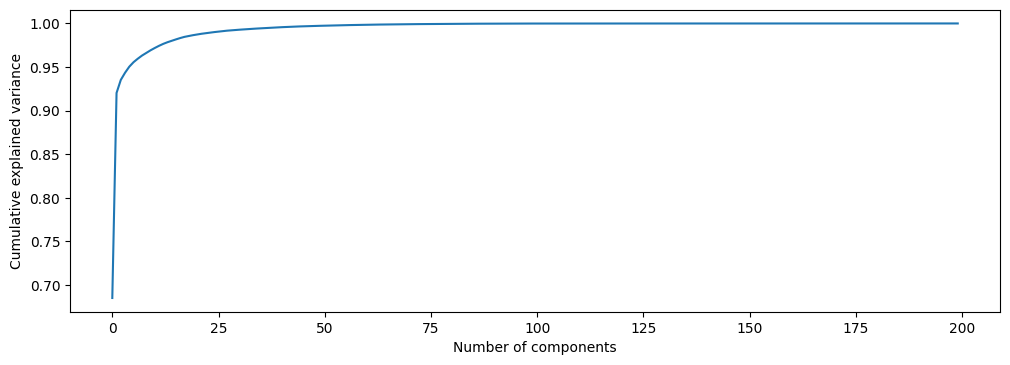

In [ ]:
from sklearn.decomposition import PCA

# Transform image to array of samples (with corresponding spectra) and ground truth to array of labels 
X, y = hsiImg, gt
r, c, d = X.shape
X = X.reshape((r * c), d)
y = y.reshape((r * c))

pca = PCA()
pcX = pca.fit_transform(X)
ev=pca.explained_variance_ratio_

fig = plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

The curve shows that practically all variance is explained with the first 50 principal components. The rest of them are likely to contain mostly noise.

We can also visualize the first principal components of the spectral bands. As we see, components with lower variance values appear more and more noisy.

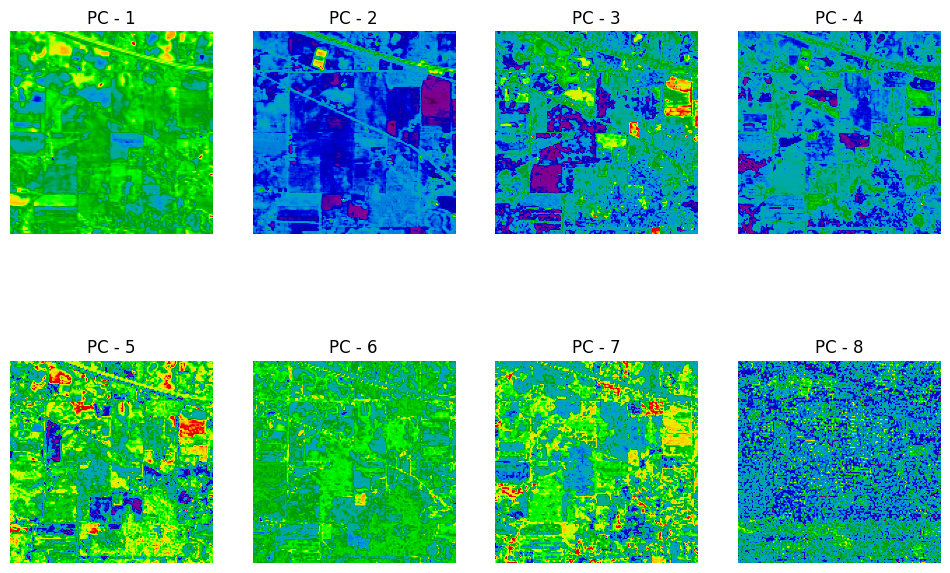

In [ ]:
X = hsi.principal_components(hsiImg, n_components=40)

fig = plt.figure(figsize=(12, 8))
for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.title(f"PC - {i}")
    plt.imshow(X[:,:,i], cmap='nipy_spectral')
    plt.axis('off')

# SVM training

We may simplify the job to the SVM model by reducing redundancy and decorrelation across spectral bands. We use the reduced bands result of the PCA to feed the classifier, removing noise and irrelevant information that won't improve the performance of our clasifier. But even if we don't want to apply a reduction of the number of components, decorrelating the bands before feeding the classifier is a good practice with classic classfifiers like support vector machines. With the IP dataset, it improves performace by a 10%.

                              precision    recall  f1-score   support

                                   0.80      0.84      0.82      3251
                     Alfalfa       0.75      0.69      0.72        13
                 Corn-notill       0.71      0.65      0.68       436
                Corn-mintill       0.72      0.62      0.67       245
                        Corn       0.58      0.50      0.54        76
               Grass-pasture       0.84      0.80      0.82       150
                 Grass-trees       0.84      0.76      0.80       244
         Grass-pasture-mowed       0.62      0.62      0.62         8
               Hay-windrowed       0.86      0.88      0.87       134
                        Oats       0.50      0.17      0.25         6
              Soybean-notill       0.73      0.69      0.71       296
             Soybean-mintill       0.77      0.78      0.77       704
               Soybean-clean       0.69      0.66      0.67       170
                   

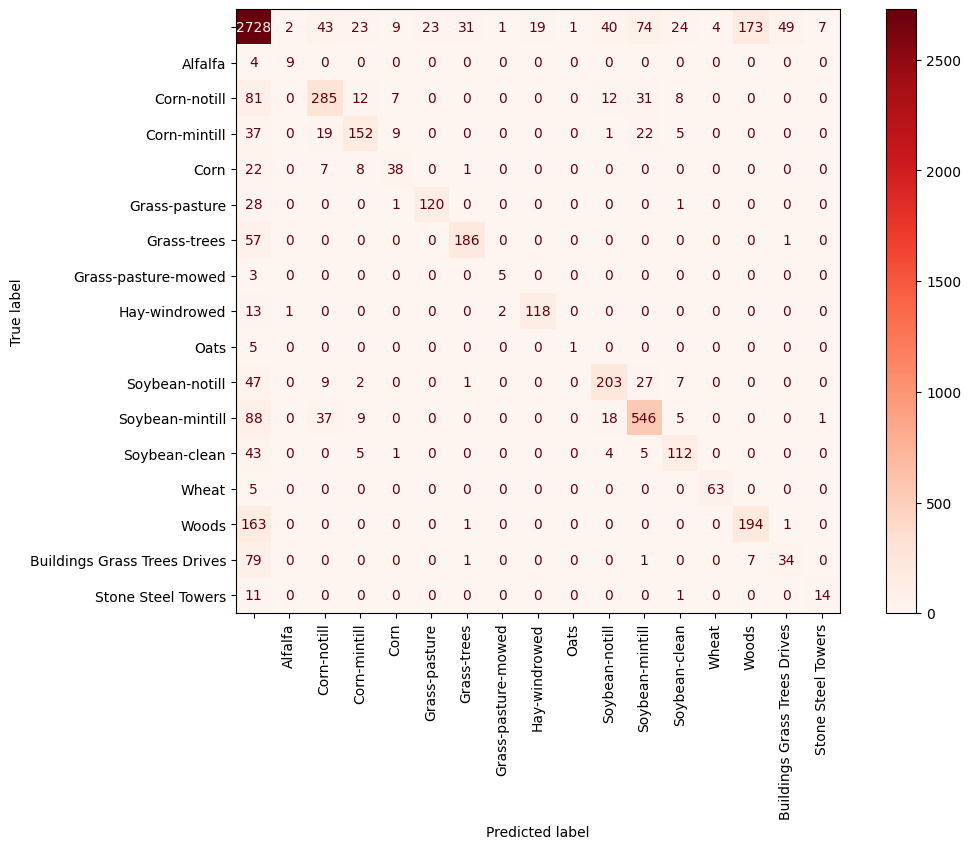

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix


# Preparing data for training and testing
r, c, d = X.shape
X = X.reshape((r * c), d)
X_train, X_test, y_train, y_test = hsi.split_train_test(X, y)

# Training the model
svm = SVC(C=150, kernel='rbf')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

plot_confusion_matrix(svm, X_test, y_test, display_labels=class_names, cmap=plt.cm.Reds, xticks_rotation='vertical', ax=plt.subplot())
print(classification_report(y_test, y_pred, target_names=class_names))

## Classification result

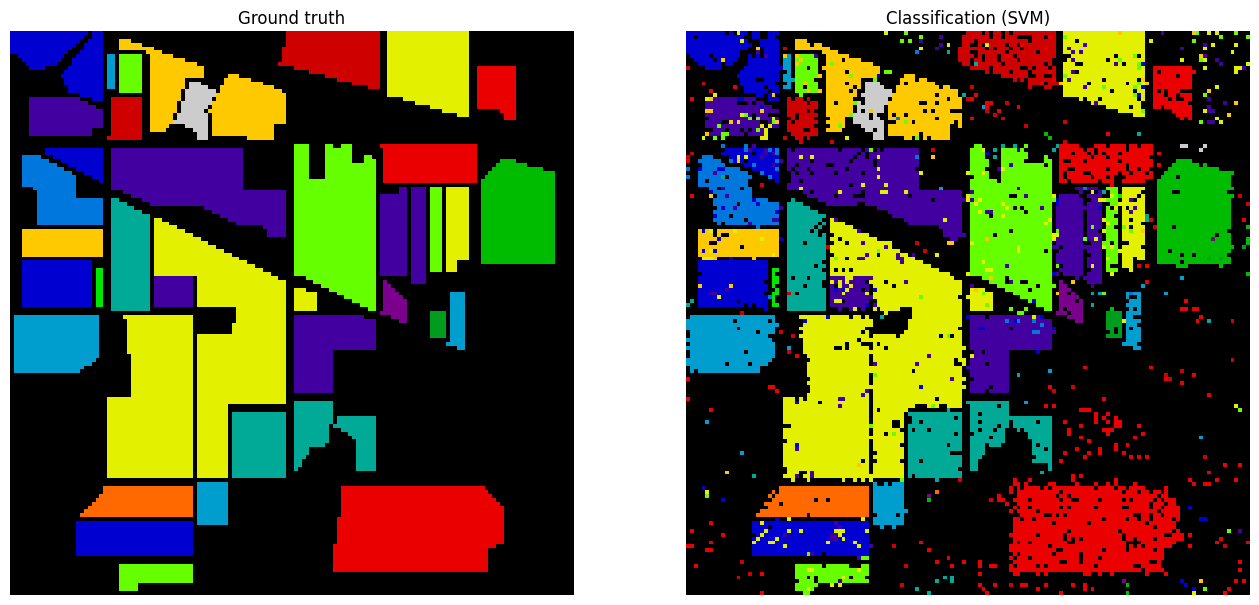

In [ ]:
clmap = svm.predict(X).reshape(r, c)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Ground truth')
plt.imshow(gt, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(122)
plt.title('Classification (SVM)')
plt.imshow(clmap, cmap='nipy_spectral')
plt.axis('off')
plt.show()